In [1]:
from pathlib import Path

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from bioinf_common.plotting import corrplot

In [2]:
sns.set_context('talk')

# Parameters

In [ ]:
result_files = snakemake.input

out_dir = Path(snakemake.output.out_dir)

# Load data

In [9]:
df_list = []
for fname in result_files:
    tmp = pd.read_csv(fname)
    
    _, tool, _, _ = fname.split('/')
    tmp['tool'] = tool
    
    df_list.append(tmp)
df = pd.concat(df_list, ignore_index=True)

In [10]:
df.head()

,term,p_value,tool
0,pw1,0.497026,dummy
1,pw2,0.256439,dummy
2,pw1,0.334024,LRpath
3,pw2,0.334024,LRpath
4,pw2,0.184158,GSEA


# Enrichment correlation between tools

In [11]:
df_wide = df.pivot(index='term', columns='tool', values='p_value')
df_wide.head()

tool,GSEA,LRpath,camera,dummy,fishers_exact_test
term,,,,,
pw1,0.177453,0.334024,0.440994,0.497026,1.0
pw2,0.184158,0.334024,0.440994,0.256439,1.0


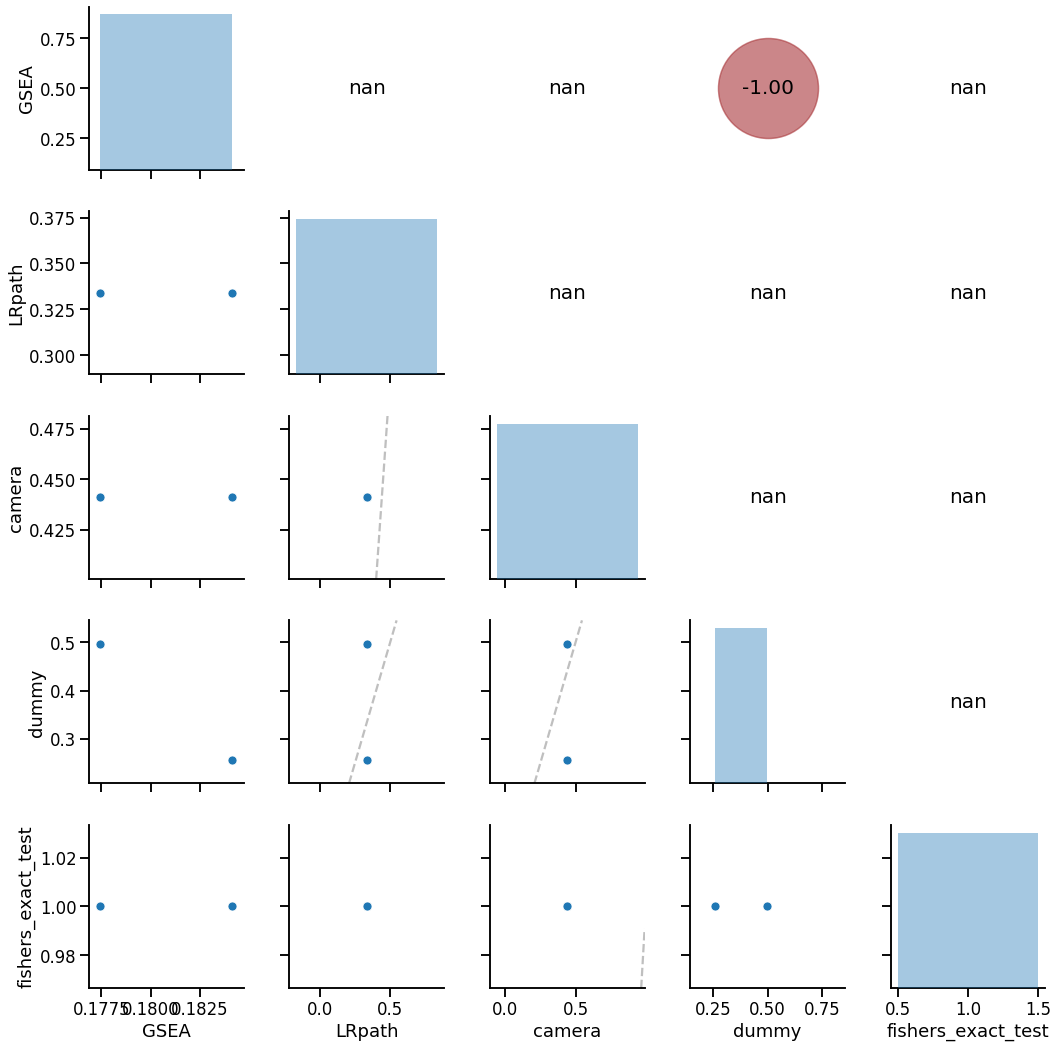

In [12]:
g = corrplot(
    df_wide,
    corr_method='spearman',
    diag_kws=dict(kde=False),
    lower_kws=dict(rasterized=True),
    diag_sharey=False, height=3
)

g.savefig(out_dir / 'pvalue_scatterplots.pdf')